In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import models, layers, optimizers
import warnings
warnings.simplefilter("ignore")
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
import os
Dir = '/content/drive/MyDrive/cassava-leaf-disease-classification'
os.listdir(Dir)

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'test_images',
 'train_tfrecords',
 'train_images',
 'test_tfrecords']

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/cassava-leaf-disease-classification')))

7


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/cassava-leaf-disease-classification')))

7


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/cassava-leaf-disease-classification/train.csv')
train_data.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

<Axes: xlabel='label', ylabel='count'>

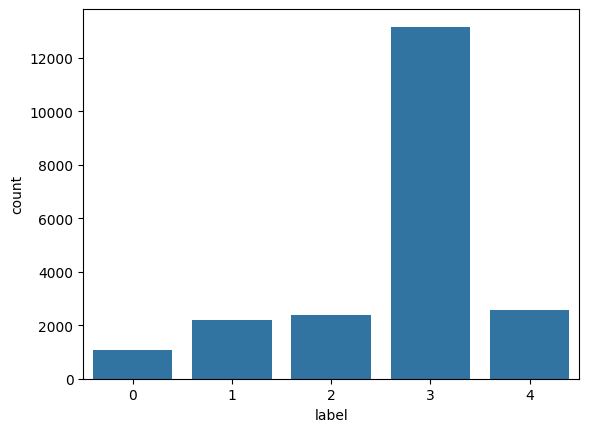

In [ ]:
sns.countplot(train_data , x = 'label')

In [ ]:
train_data['label'].value_counts()

label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64

In [ ]:
np.round((train_data['label'].value_counts()/len(train_data['label']))*100, 2)

3    61.49
4    12.04
2    11.15
1    10.23
0     5.08
Name: label, dtype: float64

In [ ]:
len(train_data)

21397

In [ ]:
import json
with open('/content/drive/MyDrive/cassava-leaf-disease-classification/label_num_to_disease_map.json') as file:
    print(json.dumps(json.loads(file.read()), indent=4))


{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [ ]:
image_dir = "/content/drive/MyDrive/cassava-leaf-disease-classification/train_images"
image_ids = os.listdir(image_dir)

plt.figure(figsize=(10, 10))
for ind, image_id in enumerate(image_ids[:9]):
    plt.subplot(3, 3, ind + 1)
    image_path = os.path.join(image_dir, image_id)
    try:
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            plt.axis("off")
    except Exception as e:
        print(f"Error loading image {image_id}: {e}")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.pyplot as plt

image_dir = "/content/drive/MyDrive/cassava-leaf-disease-classification/train_images"
image_ids = os.listdir(image_dir)

plt.figure(figsize=(10, 10))
for ind, image_id in enumerate(image_ids[:12]):
    plt.subplot(4, 3, ind + 1)
    image_path = os.path.join(image_dir, image_id)
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis("off")
    else:
        print(f"Error loading image: {image_id}")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

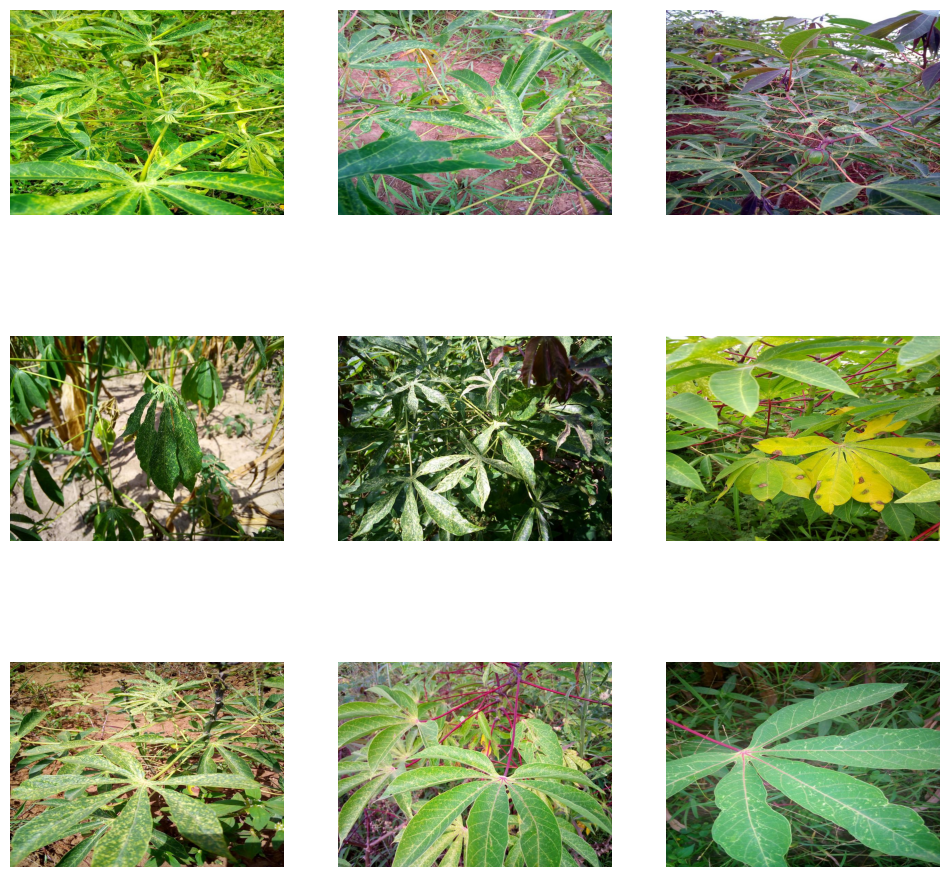

In [ ]:
sample = train_data[train_data.label == 2].sample(9)
plt.figure(figsize=(12,12))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(3, 3, ind + 1)
    image = cv2.imread(os.path.join("C:/Users/tao130/Downloads/cassava-leaf-disease-classification/train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")

plt.show()

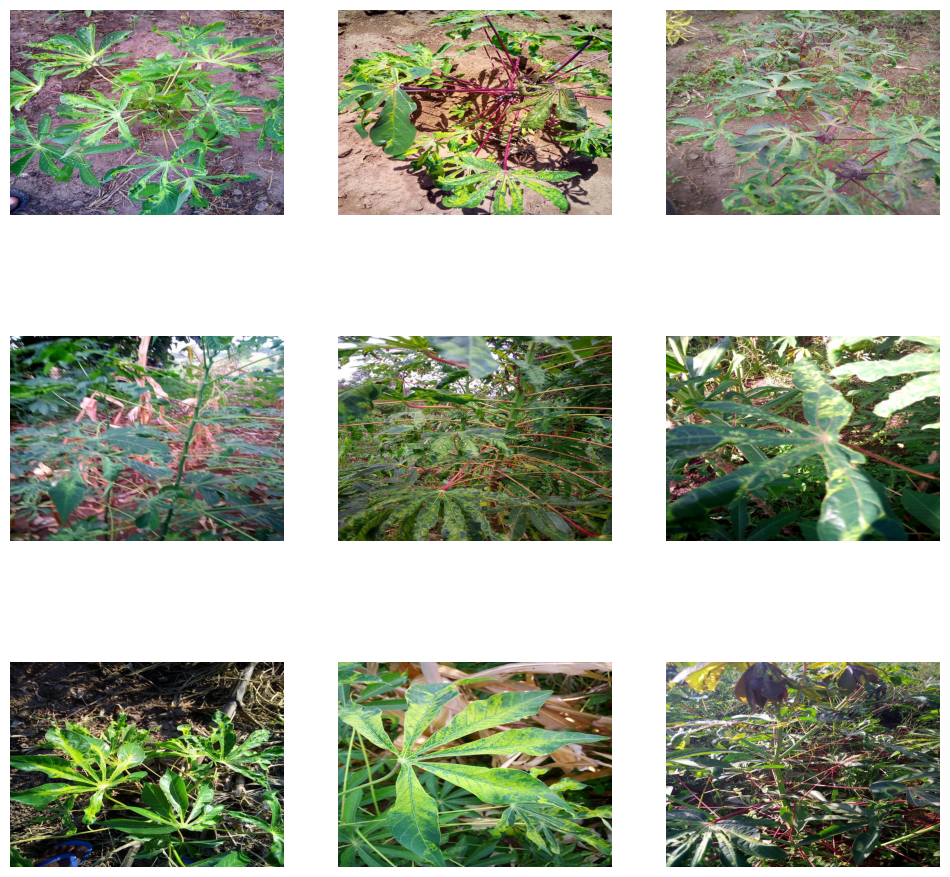

In [ ]:
sample = train_data[train_data.label == 3].sample(9)
plt.figure(figsize=(12,12))
for ind, (img_id, lab) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(3,3,ind+1)
    image = cv2.imread(os.path.join("C:/Users/tao130/Downloads/cassava-leaf-disease-classification/train_images", img_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
plt.show()

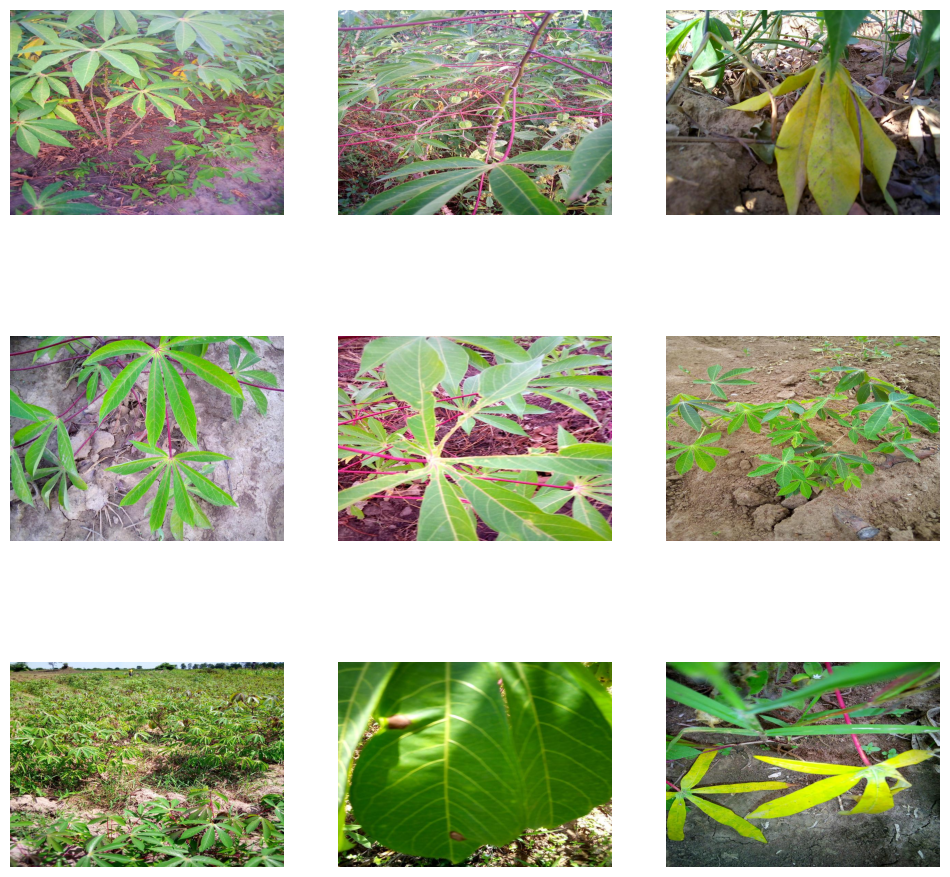

In [ ]:
sample = train_data[train_data.label == 4].sample(9)
plt.figure(figsize=(12,12))
for ind, (img_id, lab) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(3,3,ind+1)
    image = cv2.imread(os.path.join("C:/Users/tao130/Downloads/cassava-leaf-disease-classification/train_images", img_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [ ]:
y_pred = [3] * len(train_data.label)
print("The baseline accuracy is {}".format(accuracy_score(y_pred, train_data.label)))

The baseline accuracy is 0.6149460204701593


In [ ]:
Batch_size = 16
img_height, img_width = 300, 300

In [ ]:
train_data['label'].dtype

dtype('int64')

In [ ]:
train_data['label'] = train_data['label'].astype('str')
gen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2,
)

train_datagen = gen.flow_from_dataframe(
    train_data,
    directory = os.path.join(Dir, "train_images"),
    batch_size = Batch_size,
    target_size = (img_height, img_width),
    subset = "training",
    seed = 42,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 2102 validated image filenames belonging to 5 classes.


In [ ]:
val_gen = ImageDataGenerator(
    validation_split = 0.2
)

val_datagen = val_gen.flow_from_dataframe(
    train_data,
    directory = os.path.join(Dir, "train_images"),
    batch_size = Batch_size,
    target_size = (img_height, img_width),
    subset = "validation",
    seed = 42,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 525 validated image filenames belonging to 5 classes.


In [ ]:
len(train_datagen), len(val_datagen)

(132, 33)

In [ ]:
img, label = next(train_datagen)

In [ ]:
label

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
Steps_per_train = float(train_datagen.n) / train_datagen.batch_size
Steps_per_val = float(val_datagen.n) / val_datagen.batch_size

In [ ]:
Steps_per_train, Steps_per_val

(131.375, 32.8125)

In [ ]:
def create_model():
    model = models.Sequential()
    model.add(EfficientNetB3(include_top=False, weights='imagenet',
                             input_shape=(img_height, img_width, 3), drop_connect_rate=0.3))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(5, activation='softmax'))

    loss = tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=0.0001,
        name='categorical_crossentropy'
    )
    optimizer = optimizers.Adam(learning_rate=1e-4)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=["categorical_accuracy"])
    return model

model = create_model()
model.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 10, 10, 1536)      10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

In [ ]:
Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

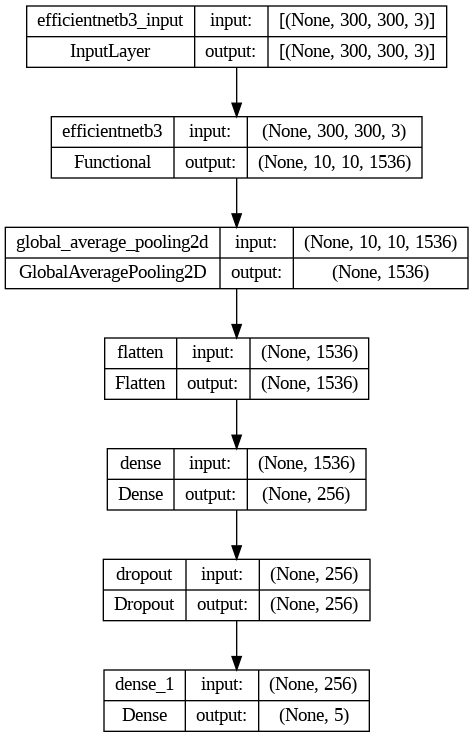

In [ ]:
# Build the model
model.build((None))

# Plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                            factor=0.2,
                                            mode = "min",
                                            min_lr=1e-6,
                                            patience=2,
                                            verbose=1)

estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                       mode= "min",
                                       patience=3,
                                       verbose=1,
                                       restore_best_weights=True)

history = model.fit(
    train_datagen,
    steps_per_epoch=int(Steps_per_train),
    epochs=5,
    verbose =1,
    validation_data=val_datagen,
    validation_steps=int(Steps_per_val),
    callbacks=[rlronp, estop]
)

Epoch 1/5
131/131 [==============================] - 2504s 19s/step - loss: 0.9694 - categorical_accuracy: 0.6371 - val_loss: 0.8007 - val_categorical_accuracy: 0.6855 - lr: 1.0000e-04
Epoch 2/5
131/131 [==============================] - 2313s 18s/step - loss: 0.6613 - categorical_accuracy: 0.7685 - val_loss: 0.6785 - val_categorical_accuracy: 0.7637 - lr: 1.0000e-04
Epoch 3/5
131/131 [==============================] - 2321s 18s/step - loss: 0.4976 - categorical_accuracy: 0.8092 - val_loss: 0.6572 - val_categorical_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 4/5
131/131 [==============================] - 2346s 18s/step - loss: 0.4032 - categorical_accuracy: 0.8571 - val_loss: 0.6922 - val_categorical_accuracy: 0.7539 - lr: 1.0000e-04
Epoch 5/5
131/131 [==============================] - ETA: 0s - loss: 0.3275 - categorical_accuracy: 0.8845 
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
131/131 [==============================] - 2347s 18s/step - loss: 0.3275 - 

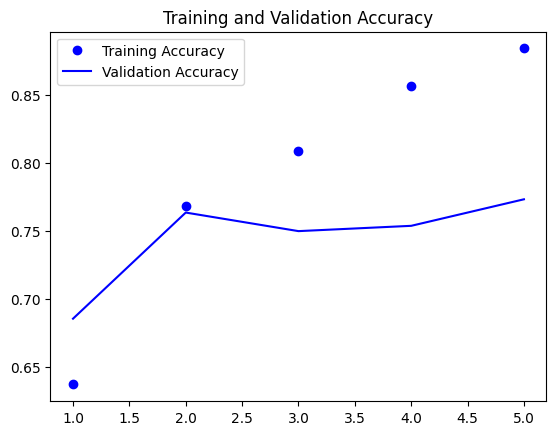

In [ ]:
train_acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, "bo", label = "Training Accuracy")
plt.plot(epochs, val_acc, "b", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()